In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import optuna
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.metrics import recall_score, precision_score, f1_score, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import shap 


1. Зареждане на данните:

In [ ]:
file_path = '*/Churn_Modelling.csv' #Add path to the dataset file here
raw_data = pd.read_csv(file_path)

In [3]:
raw_data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42.0,2,0.00,1,1.0,1.0,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41.0,1,83807.86,1,0.0,1.0,112542.58,0
2,3,15619304,Onio,502,France,Female,42.0,8,159660.80,3,1.0,0.0,113931.57,1
3,4,15701354,Boni,699,France,Female,39.0,1,0.00,2,0.0,0.0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43.0,2,125510.82,1,NaN,1.0,79084.10,0


2. Предварителна обработка на данните:

In [4]:
# Basic inspection and overview of the dataset
print("Shape of data:", raw_data.shape)
print("\nColumn names:", raw_data.columns.tolist())
display(raw_data.head())

# Check for missing values
print("\nMissing values:\n", raw_data.isnull().sum())

# Check data types
print("\nData types:\n", raw_data.dtypes)


Shape of data: (10002, 14)

Column names: ['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited']


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42.0,2,0.00,1,1.0,1.0,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41.0,1,83807.86,1,0.0,1.0,112542.58,0
2,3,15619304,Onio,502,France,Female,42.0,8,159660.80,3,1.0,0.0,113931.57,1
3,4,15701354,Boni,699,France,Female,39.0,1,0.00,2,0.0,0.0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43.0,2,125510.82,1,NaN,1.0,79084.10,0



Missing values:
 RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          1
Gender             0
Age                1
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          1
IsActiveMember     1
EstimatedSalary    0
Exited             0
dtype: int64

Data types:
 RowNumber            int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                float64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard          float64
IsActiveMember     float64
EstimatedSalary    float64
Exited               int64
dtype: object


In [5]:
# Drop unessential columns
data = raw_data.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

#drop all the missing values as number is low and it doesnt introduce bias
print(raw_data.shape)
data = data.dropna()

print(data.isnull().sum())  # Should all be zero
print("Shape after dropping missing:", data.shape)



(10002, 14)
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64
Shape after dropping missing: (9998, 11)


In [6]:
#check for duplicates
duplicates = data.duplicated().sum()
print(f"\nNumber of duplicate rows: {duplicates}")

#remove duplicates
data = data.drop_duplicates()
duplicates = data.duplicated().sum()
print(f"\nNumber of duplicate rows after cleanup: {duplicates}")


Number of duplicate rows: 2

Number of duplicate rows after cleanup: 0


## EDA

In [7]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
CreditScore,9996.0,650.503301,96.624668,350.00,584.00,652.00,717.2500,850.00
Age,9996.0,38.921071,10.488421,18.00,32.00,37.00,44.0000,92.00
Tenure,9996.0,5.013305,2.892353,0.00,3.00,5.00,7.2500,10.00
Balance,9996.0,76476.263216,62397.118820,0.00,0.00,97173.29,127639.3725,250898.09
NumOfProducts,9996.0,1.530212,0.581684,1.00,1.00,1.00,2.0000,4.00
HasCrCard,9996.0,0.705482,0.455849,0.00,0.00,1.00,1.0000,1.00
IsActiveMember,9996.0,0.514906,0.499803,0.00,0.00,1.00,1.0000,1.00
EstimatedSalary,9996.0,100106.701248,57513.314398,11.58,51002.11,100238.11,149400.1075,199992.48
Exited,9996.0,0.203782,0.402829,0.00,0.00,0.00,0.0000,1.00


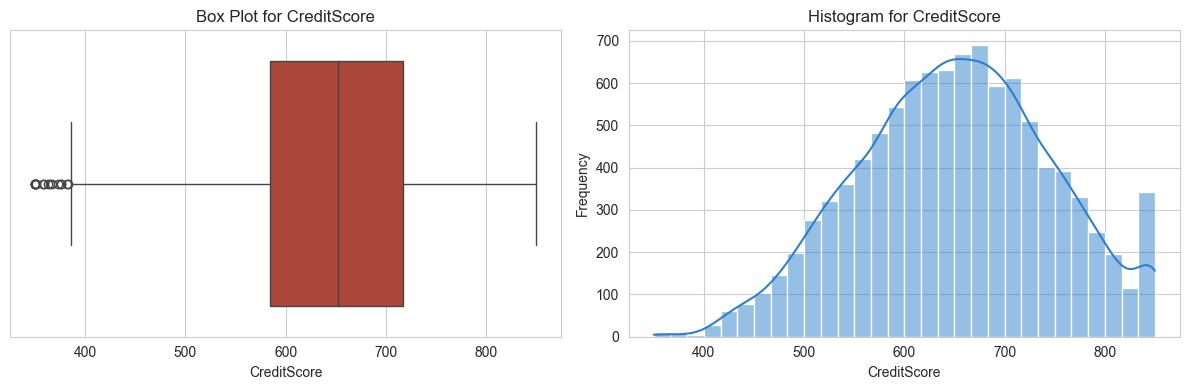

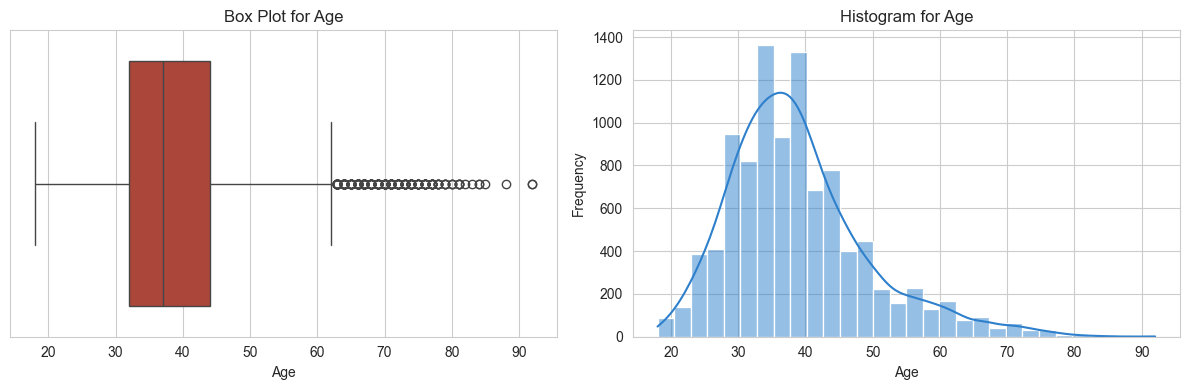

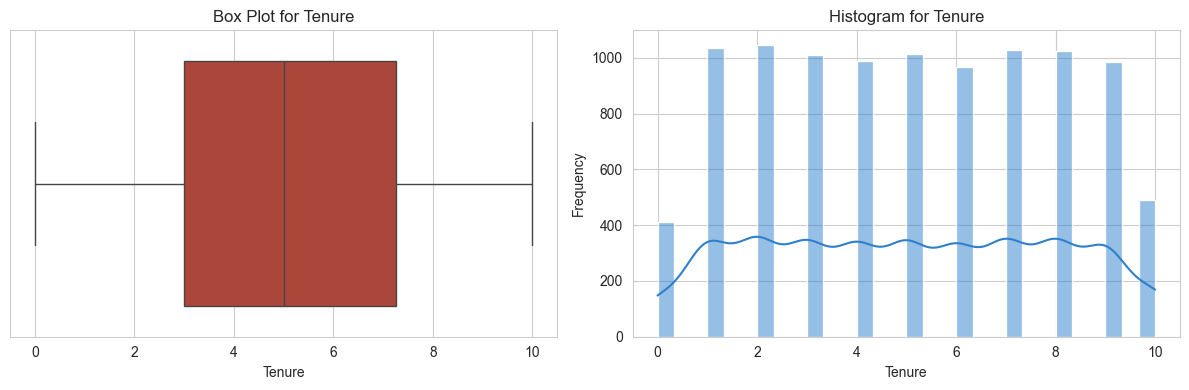

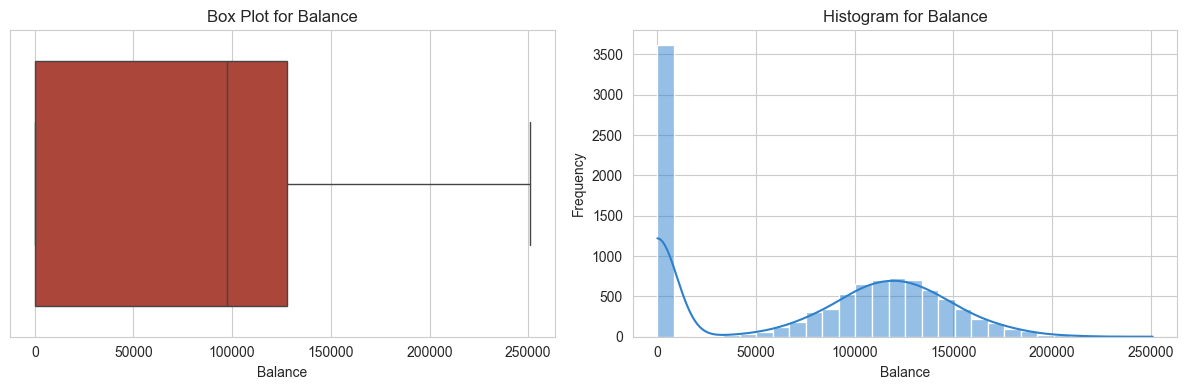

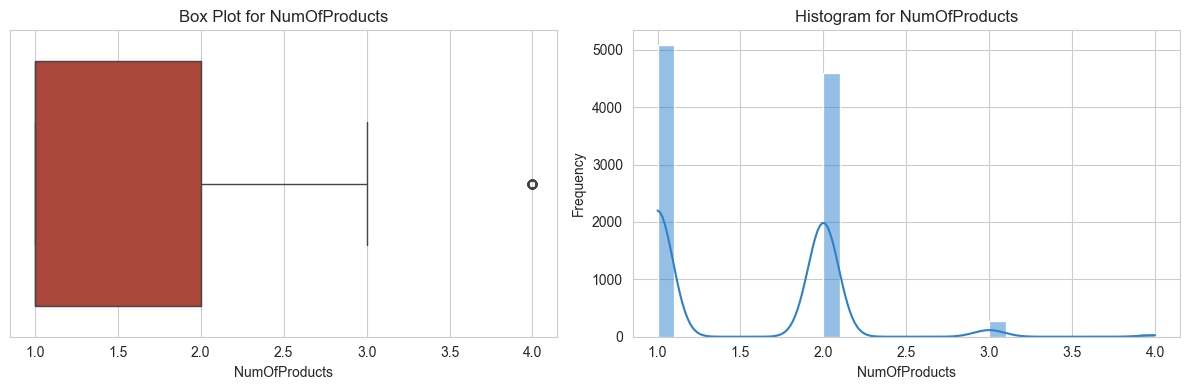

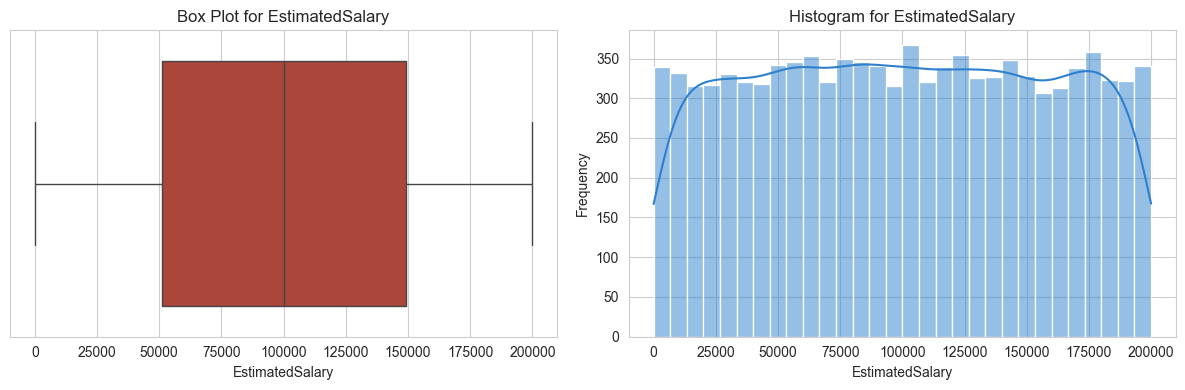

In [8]:
custom_palette = ["#be3728", "#2e80cc", "#42bc27cb", "#3c3c3c", "#8e44ad"]

def create_variable_plots(variable, df):
    sns.set_style('whitegrid')
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Box plot
    sns.boxplot(x=df[variable], color=custom_palette[0], ax=axes[0])
    axes[0].set_xlabel(variable)
    axes[0].set_title(f"Box Plot for {variable}")

    # Histogram
    sns.histplot(df[variable], color=custom_palette[1], kde=True, bins=30, ax=axes[1])
    axes[1].set_xlabel(variable)
    axes[1].set_ylabel("Frequency")
    axes[1].set_title(f"Histogram for {variable}")

    plt.tight_layout()
    plt.show()

# List numerical variables 
numerical_cols = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

# Plot for each numerical variable
for variable in numerical_cols:
    create_variable_plots(variable, data)


#### Findings: Numerical Feature Distributions

- **CreditScore:** Approximately normal, centered ~650, with minor low-end outliers.
- **Age:** Right-skewed, median ~37, several high-value outliers (>65).
- **Tenure:** Uniformly distributed across 0–10.
- **Balance:** Bimodal; substantial proportion at zero, second mode near 125k.
- **NumOfProducts:** Bimodal (1 or 2), few with 3 or 4.
- **EstimatedSalary:** Uniformly distributed.

**Note:** Some features (Age, Balance) show skewness and outliers, next should perform scaling and transformation 

/var/folders/dg/j_kcyvsj1q9b63g75yrkt0y5ny5_9l/T/ipykernel_51613/4160627914.py:6: UserWarning: The palette list has more values (5) than needed (3), which may not be intended.
  sns.countplot(x=col, data=data, hue=col, palette=custom_palette, legend=False, width=0.3)


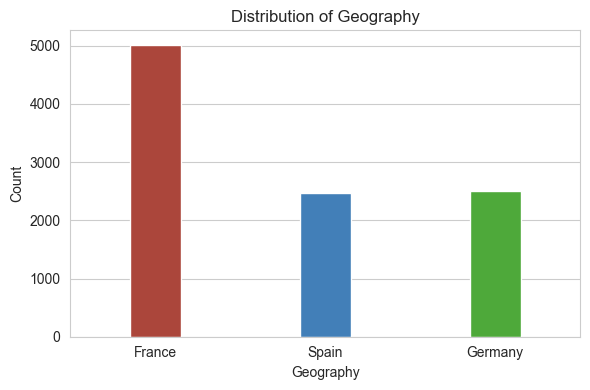

/var/folders/dg/j_kcyvsj1q9b63g75yrkt0y5ny5_9l/T/ipykernel_51613/4160627914.py:6: UserWarning: The palette list has more values (5) than needed (2), which may not be intended.
  sns.countplot(x=col, data=data, hue=col, palette=custom_palette, legend=False, width=0.3)


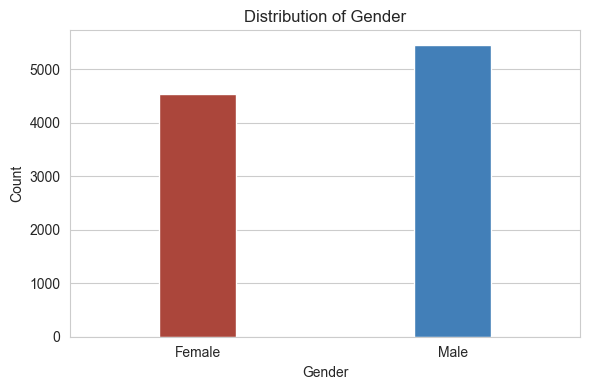

/var/folders/dg/j_kcyvsj1q9b63g75yrkt0y5ny5_9l/T/ipykernel_51613/4160627914.py:6: UserWarning: The palette list has more values (5) than needed (2), which may not be intended.
  sns.countplot(x=col, data=data, hue=col, palette=custom_palette, legend=False, width=0.3)


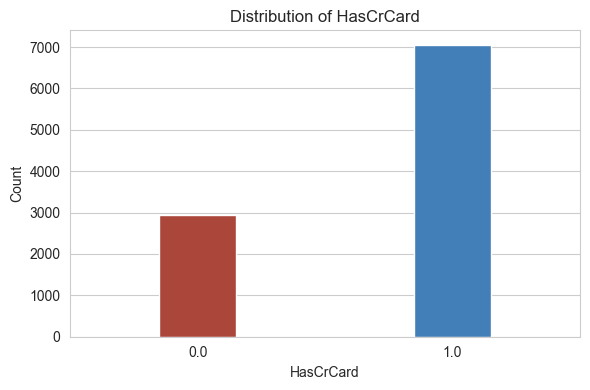

/var/folders/dg/j_kcyvsj1q9b63g75yrkt0y5ny5_9l/T/ipykernel_51613/4160627914.py:6: UserWarning: The palette list has more values (5) than needed (2), which may not be intended.
  sns.countplot(x=col, data=data, hue=col, palette=custom_palette, legend=False, width=0.3)


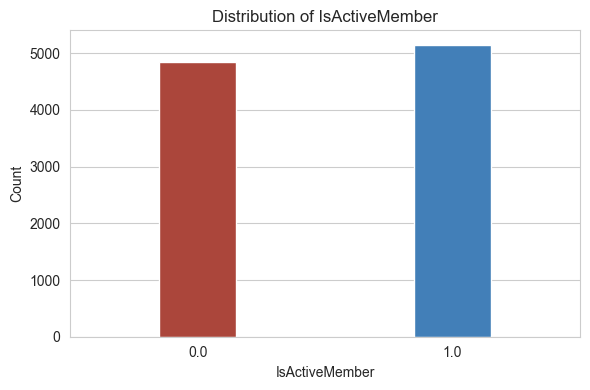

In [9]:
# Explore categorical variables
cat_cols = ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember']

for col in cat_cols:
    plt.figure(figsize=(6,4))
    sns.countplot(x=col, data=data, hue=col, palette=custom_palette, legend=False, width=0.3)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

note: Class imbalance for HasCrCard, IsActiveMember (target) and Country

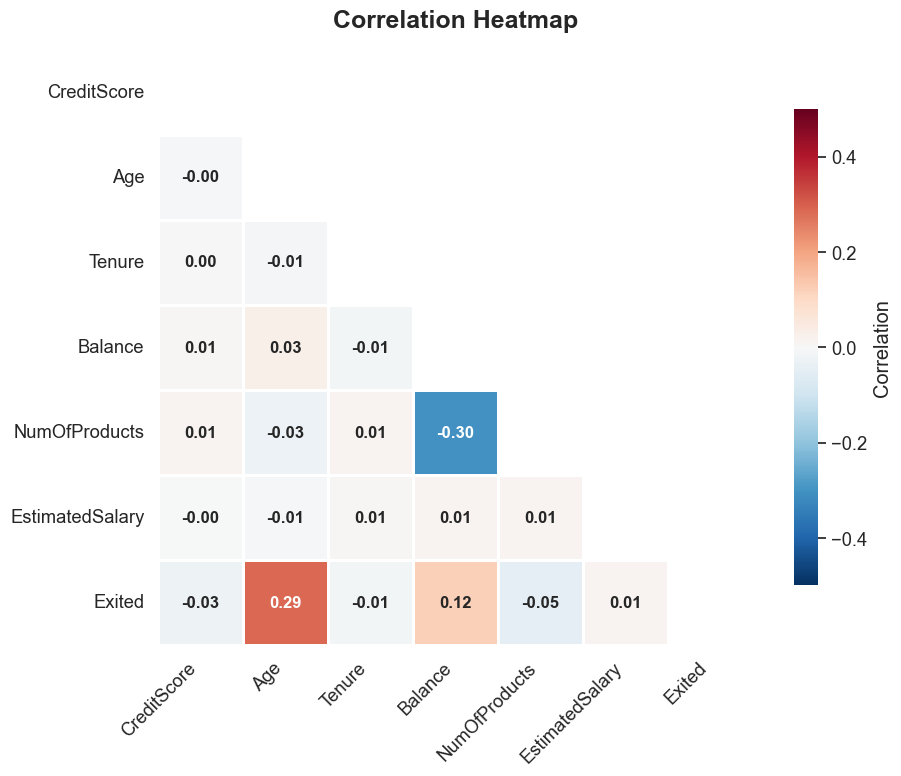

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
corr = data[numerical_cols + ['Exited']].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

sns.set(font_scale=1.2)
ax = sns.heatmap(
    corr, 
    mask=mask,
    annot=True, 
    fmt='.2f', 
    cmap='RdBu_r', 
    center=0, 
    linewidths=1, 
    linecolor='white', 
    square=True, 
    cbar_kws={'shrink': 0.8, 'aspect': 20, 'label': 'Correlation'},
    annot_kws={"size": 12, "weight": "bold"},
    vmin=-0.5, vmax=0.5
)
ax.set_facecolor('white')
plt.title('Correlation Heatmap', fontsize=18, weight='bold', pad=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


note: age has the strongest positive correlation (0.29) and balance is second best with (0.12), multicolinearity unlikely

In [11]:
#one-hot encoding for categorical variables
df_encoded = data.copy()
df_encoded['Gender'] = df_encoded['Gender'].map({'Female': 0, 'Male': 1})
df_encoded = pd.get_dummies(df_encoded, columns=['Geography'], drop_first=True).astype(int)
print(df_encoded.head(5))

   CreditScore  Gender  Age  Tenure  Balance  NumOfProducts  HasCrCard  \
0          619       0   42       2        0              1          1   
1          608       0   41       1    83807              1          0   
2          502       0   42       8   159660              3          1   
3          699       0   39       1        0              2          0   
5          645       1   44       8   113755              2          1   

   IsActiveMember  EstimatedSalary  Exited  Geography_Germany  Geography_Spain  
0               1           101348       1                  0                0  
1               1           112542       0                  0                1  
2               0           113931       1                  0                0  
3               0            93826       0                  0                0  
5               0           149756       1                  0                1  


In [12]:
#outliers detection 
outlier_summary = {}

for col in numerical_cols:
    Q1 = df_encoded[col].quantile(0.25)
    Q3 = df_encoded[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df_encoded[(df_encoded[col] < lower_bound) | (df_encoded[col] > upper_bound)][col]
    outlier_summary[col] = {
        'lower_bound': lower_bound,
        'upper_bound': upper_bound,
        'num_outliers': outliers.count(),
        'outlier_percentage': 100 * outliers.count() / len(df_encoded)
    }

# Show outlier counts and percentages
outlier_df = pd.DataFrame(outlier_summary).T
print(outlier_df)

                 lower_bound  upper_bound  num_outliers  outlier_percentage
CreditScore          384.125      917.125          16.0            0.160064
Age                   14.000       62.000         359.0            3.591437
Tenure                -3.375       13.625           0.0            0.000000
Balance          -191458.500   319097.500           0.0            0.000000
NumOfProducts         -0.500        3.500          60.0            0.600240
EstimatedSalary   -96594.875   296996.125           0.0            0.000000


note: the outliers are less than 5% will keep

In [13]:
#train-test split
X = df_encoded.drop('Exited', axis=1)
y = df_encoded['Exited']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=365,
    stratify=y
)

num_cols = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary'] #without the target variable
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])


In [14]:
print("Train mean:\n", X_train[num_cols].mean())
print("\nTrain std:\n", X_train[num_cols].std())
print("\nX_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)


Train mean:
 CreditScore       -3.137883e-16
Age                6.042203e-17
Tenure             1.584174e-16
Balance           -8.885592e-17
NumOfProducts      1.127201e-16
EstimatedSalary   -1.421695e-17
dtype: float64

Train std:
 CreditScore        1.000071
Age                1.000071
Tenure             1.000071
Balance            1.000071
NumOfProducts      1.000071
EstimatedSalary    1.000071
dtype: float64

X_train shape: (6997, 11)
X_test shape: (2999, 11)


In [15]:
# Model 1: Logistic Regression

#Fit Logistic Regression (handle class imbalance with 'balanced')
logreg = LogisticRegression(
    class_weight='balanced',
    random_state=365,
    max_iter=1000
)
logreg.fit(X_train, y_train)

# Predict
y_pred_logreg = logreg.predict(X_test)
y_proba_logreg = logreg.predict_proba(X_test)[:, 1]

# Evaluation
print("=== Logistic Regression Classification Report ===")
print(classification_report(y_test, y_pred_logreg, digits=3))
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba_logreg):.3f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_logreg)
print("Confusion Matrix:\n", cm)

=== Logistic Regression Classification Report ===
              precision    recall  f1-score   support

           0      0.899     0.711     0.794      2388
           1      0.379     0.687     0.488       611

    accuracy                          0.707      2999
   macro avg      0.639     0.699     0.641      2999
weighted avg      0.793     0.707     0.732      2999

ROC-AUC: 0.769
Confusion Matrix:
 [[1699  689]
 [ 191  420]]


In [16]:
#feature importance based on coefficients
coef = pd.Series(logreg.coef_[0], index=X_train.columns)
coef = coef.sort_values(key=abs, ascending=False)
print("\nTop Features by Absolute Coefficient (Importance):")
print(coef.head(10))



Top Features by Absolute Coefficient (Importance):
IsActiveMember      -0.911215
Age                  0.811316
Geography_Germany    0.765353
Gender              -0.540000
Balance              0.206569
Geography_Spain      0.129495
CreditScore         -0.065748
NumOfProducts       -0.060551
Tenure              -0.053378
HasCrCard           -0.024864
dtype: float64


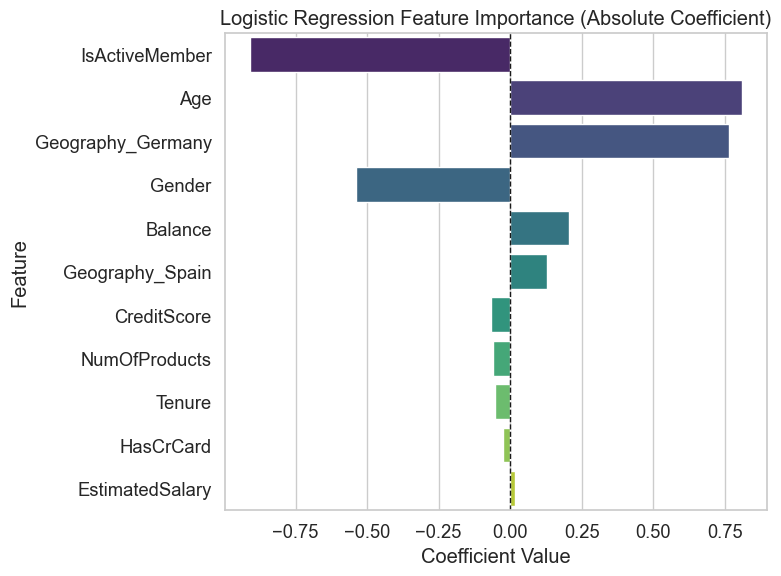

In [17]:
coef = pd.Series(logreg.coef_[0], index=X_train.columns)
coef = coef.reindex(coef.abs().sort_values(ascending=False).index).reset_index()
coef.columns = ['Feature', 'Coefficient']

plt.figure(figsize=(8, 6))
sns.set_style('whitegrid')
sns.barplot(
    data=coef,
    y='Feature',
    x='Coefficient',
    hue='Feature',  
    palette=sns.color_palette('viridis', n_colors=coef.shape[0]),
    legend=False
)

plt.axvline(0, color='k', linestyle='--', linewidth=1)
plt.title('Logistic Regression Feature Importance (Absolute Coefficient)')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()



In [18]:
#Model 2: XGBoost Classifier
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    subsample=1.0,
    colsample_bytree=1.0,
    scale_pos_weight=scale_pos_weight,
    random_state=365,
    eval_metric='logloss'
)

# Fit model
xgb_model.fit(X_train, y_train)

# Predict
y_pred_xgb = xgb_model.predict(X_test)
y_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

# Evaluation
print("=== XGBoost Classification Report ===")
print(classification_report(y_test, y_pred_xgb, digits=3))
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba_xgb):.3f}")

cm = confusion_matrix(y_test, y_pred_xgb)
print("Confusion Matrix:\n", cm)


=== XGBoost Classification Report ===
              precision    recall  f1-score   support

           0      0.923     0.813     0.865      2388
           1      0.502     0.736     0.597       611

    accuracy                          0.798      2999
   macro avg      0.713     0.775     0.731      2999
weighted avg      0.838     0.798     0.810      2999

ROC-AUC: 0.863
Confusion Matrix:
 [[1942  446]
 [ 161  450]]


/var/folders/dg/j_kcyvsj1q9b63g75yrkt0y5ny5_9l/T/ipykernel_51613/3864611320.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


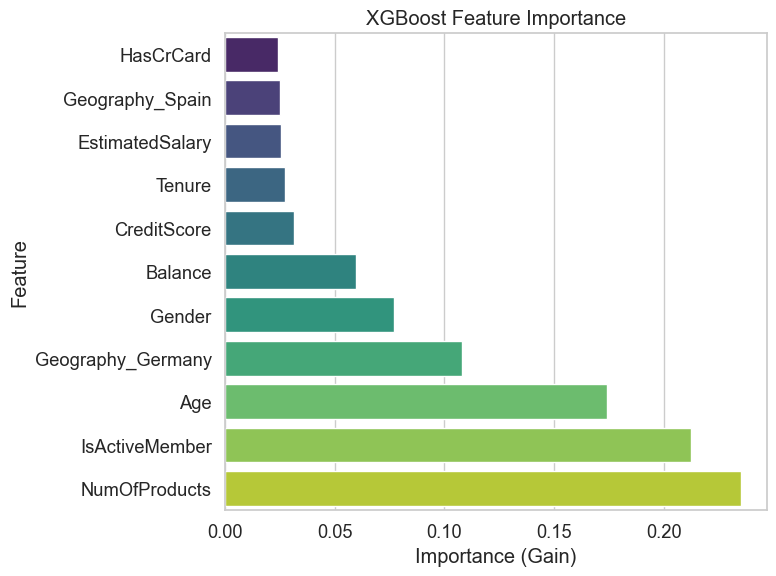

In [19]:
# Feature importance plot for XGBoost

importance = pd.Series(xgb_model.feature_importances_, index=X_train.columns)
importance = importance.sort_values(ascending=True)

plt.figure(figsize=(8, 6))
sns.set_style('whitegrid')
sns.barplot(
    x=importance.values,
    y=importance.index,
    palette=sns.color_palette('viridis', n_colors=len(importance)),
)
plt.title('XGBoost Feature Importance')
plt.xlabel('Importance (Gain)')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


In [20]:
#Hyperparameter tuning for logistic regression
param_grid_logreg = {
    'C': [0.01, 0.1, 1, 10, 100],         
    'penalty': ['l2'],                    
    'class_weight': ['balanced'],         
    'solver': ['lbfgs'],
    'max_iter': [1000],
    'random_state': [365]
}

# Grid search
grid_logreg = GridSearchCV(
    LogisticRegression(),
    param_grid=param_grid_logreg,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)
grid_logreg.fit(X_train, y_train)

print("Best Logistic Regression Params:", grid_logreg.best_params_)
best_logreg = grid_logreg.best_estimator_

# Predict and evaluate
y_pred_logreg = best_logreg.predict(X_test)
y_proba_logreg = best_logreg.predict_proba(X_test)[:, 1]


Best Logistic Regression Params: {'C': 0.01, 'class_weight': 'balanced', 'max_iter': 1000, 'penalty': 'l2', 'random_state': 365, 'solver': 'lbfgs'}


In [21]:
#Hyperparameter tuning for XGBoost
param_dist_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 6],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 1.0],
    'scale_pos_weight': [scale_pos_weight],  # already calculated for imbalance
    'random_state': [365]
}

xgb_search = RandomizedSearchCV(
    XGBClassifier(eval_metric='logloss'),
    param_distributions=param_dist_xgb,
    n_iter=20,            
    cv=3,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=365
)
xgb_search.fit(X_train, y_train)

print("Best XGBoost Params:", xgb_search.best_params_)
best_xgb = xgb_search.best_estimator_

# Predict and evaluate
y_pred_xgb = best_xgb.predict(X_test)
y_proba_xgb = best_xgb.predict_proba(X_test)[:, 1]


Best XGBoost Params: {'subsample': 0.8, 'scale_pos_weight': np.float64(3.9067321178120618), 'random_state': 365, 'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.01, 'colsample_bytree': 0.7}


### Evaluation and comparison on tuned models

In [22]:
results = pd.DataFrame({
    "Model": ["Logistic Regression (Tuned)", "XGBoost (Tuned)"],
    "Accuracy": [
        (y_test == y_pred_logreg).mean(),
        (y_test == y_pred_xgb).mean()
    ],
    "Recall (Churn)": [
        recall_score(y_test, y_pred_logreg, pos_label=1),
        recall_score(y_test, y_pred_xgb, pos_label=1)
    ],
    "Precision (Churn)": [
        precision_score(y_test, y_pred_logreg, pos_label=1),
        precision_score(y_test, y_pred_xgb, pos_label=1)
    ],
    "F1 (Churn)": [
        f1_score(y_test, y_pred_logreg, pos_label=1),
        f1_score(y_test, y_pred_xgb, pos_label=1)
    ],
    "ROC-AUC": [
        roc_auc_score(y_test, y_proba_logreg),
        roc_auc_score(y_test, y_proba_xgb)
    ]
})

print(results)

                         Model  Accuracy  Recall (Churn)  Precision (Churn)  \
0  Logistic Regression (Tuned)  0.711237        0.689034           0.383774   
1              XGBoost (Tuned)  0.804935        0.752864           0.514541   

   F1 (Churn)   ROC-AUC  
0    0.492974  0.769512  
1    0.611296  0.867621  


Lets try to use Optune for tuning XGBoost

In [23]:
# split the training data into tuning and validation sets
from sklearn.model_selection import train_test_split

X_tune, X_valid, y_tune, y_valid = train_test_split(
    X_train, y_train, test_size=0.2, random_state=365, stratify=y_train
)


In [41]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 80, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 8),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),
        'scale_pos_weight': scale_pos_weight,
        'random_state': 365,
        'eval_metric': 'auc'
    }
    model = xgb.XGBClassifier(**params)
    model.fit(
        X_tune, y_tune,
        eval_set=[(X_valid, y_valid)],
        verbose=False
    )
    y_proba = model.predict_proba(X_valid)[:, 1]
    return roc_auc_score(y_valid, y_proba)


In [42]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

print("Best Optuna Params:", study.best_params)
print("Best Optuna ROC-AUC:", study.best_value)


[I 2025-08-11 11:12:32,678] A new study created in memory with name: no-name-4dfa8334-4890-441b-957d-3a8d957f8db6
[I 2025-08-11 11:12:33,096] Trial 0 finished with value: 0.8783793564629061 and parameters: {'n_estimators': 108, 'max_depth': 5, 'learning_rate': 0.021822853861733913, 'subsample': 0.7898971443201959, 'colsample_bytree': 0.9179895933917308}. Best is trial 0 with value: 0.8783793564629061.
[I 2025-08-11 11:12:33,355] Trial 1 finished with value: 0.878779010306034 and parameters: {'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.026527934170835096, 'subsample': 0.8395327627581971, 'colsample_bytree': 0.8206896155885578}. Best is trial 1 with value: 0.878779010306034.
[I 2025-08-11 11:12:33,668] Trial 2 finished with value: 0.8767178034773032 and parameters: {'n_estimators': 222, 'max_depth': 7, 'learning_rate': 0.020101246515487434, 'subsample': 0.8519878162371272, 'colsample_bytree': 0.7770355330925389}. Best is trial 1 with value: 0.878779010306034.
[I 2025-08-11 11

Best Optuna Params: {'n_estimators': 80, 'max_depth': 5, 'learning_rate': 0.06083004364835999, 'subsample': 0.8138441145006435, 'colsample_bytree': 0.8123480021689169}
Best Optuna ROC-AUC: 0.8804783258594918


In [43]:
# Prepare final parameter dict
best_params = study.best_params.copy()
best_params['scale_pos_weight'] = scale_pos_weight
best_params['random_state'] = 365
best_params['eval_metric'] = 'logloss'

# Train on the FULL training set
best_model = xgb.XGBClassifier(**best_params)
best_model.fit(X_train, y_train)

# Predict & evaluate
y_pred_optuna = best_model.predict(X_test)
y_proba_optuna = best_model.predict_proba(X_test)[:, 1]

from sklearn.metrics import classification_report, roc_auc_score
print(classification_report(y_test, y_pred_optuna, digits=3))
print('ROC-AUC:', roc_auc_score(y_test, y_proba_optuna))


              precision    recall  f1-score   support

           0      0.927     0.812     0.866      2388
           1      0.506     0.750     0.604       611

    accuracy                          0.800      2999
   macro avg      0.716     0.781     0.735      2999
weighted avg      0.841     0.800     0.812      2999

ROC-AUC: 0.866355783280834


| Model                       | Accuracy | Recall (Churn) | Precision (Churn) | F1 (Churn) | ROC-AUC |
| --------------------------- | -------- | -------------- | ----------------- | ---------- | ------- |
| Logistic Regression (Tuned) | 0.711    | 0.689          | 0.384             | 0.493      | 0.770   |
| XGBoost (Tuned)             | 0.805    | 0.753          | 0.515             | 0.611      | 0.868   |
| XGBoost (Optuna-Tuned)      | 0.805    | 0.759          | 0.514             | 0.613      | 0.868   |


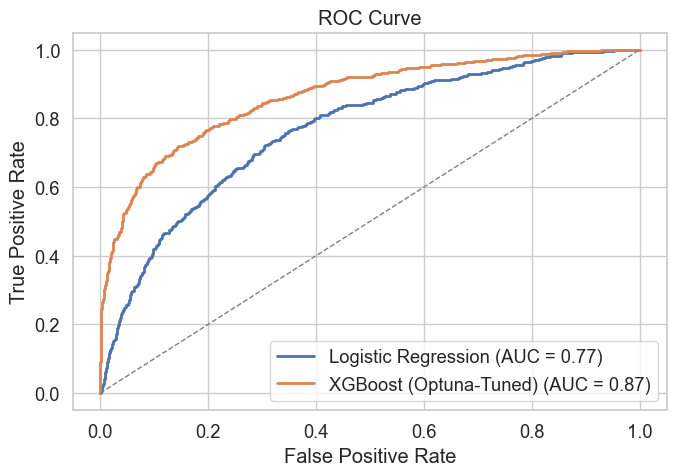

In [44]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 5))
for y_proba, label in [
    (y_proba_logreg, "Logistic Regression"),
    (y_proba_optuna, "XGBoost (Optuna-Tuned)")
]:
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{label} (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--', lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


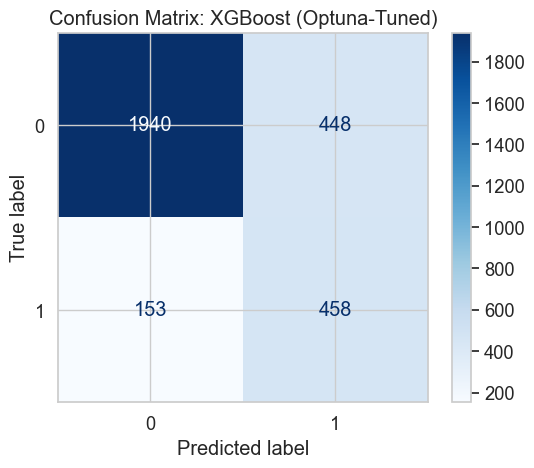

In [45]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_optuna, cmap="Blues")
plt.title("Confusion Matrix: XGBoost (Optuna-Tuned)")
plt.show()


<Figure size 600x500 with 0 Axes>

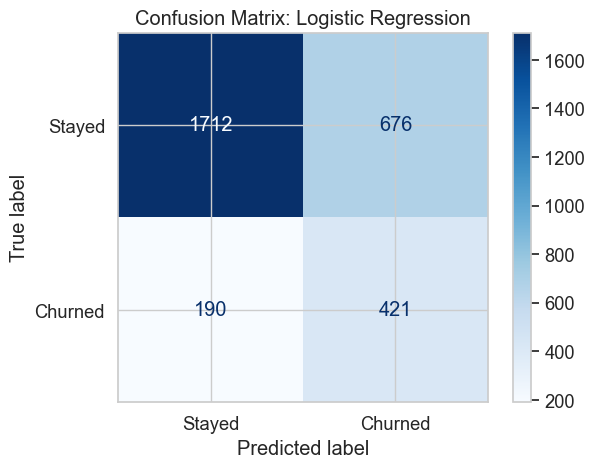

In [46]:
from sklearn.metrics import ConfusionMatrixDisplay

plt.figure(figsize=(6, 5))
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_logreg,
    cmap="Blues",
    display_labels=["Stayed", "Churned"],
    values_format='d'
)
plt.title("Confusion Matrix: Logistic Regression")
plt.show()


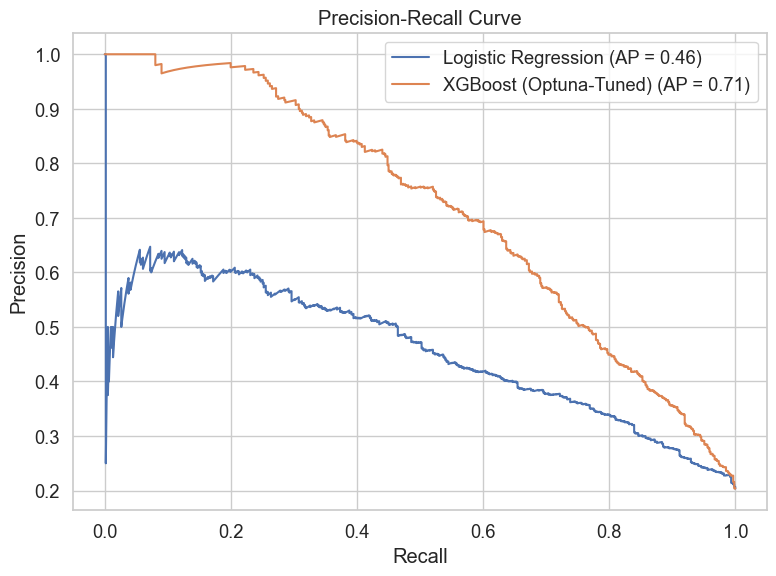

In [47]:
from sklearn.metrics import precision_recall_curve, average_precision_score
precision_logreg, recall_logreg, _ = precision_recall_curve(y_test, y_proba_logreg)
precision_xgb, recall_xgb, _ = precision_recall_curve(y_test, y_proba_optuna)

ap_logreg = average_precision_score(y_test, y_proba_logreg)
ap_xgb = average_precision_score(y_test, y_proba_optuna)

plt.figure(figsize=(8, 6))
plt.plot(recall_logreg, precision_logreg, label=f"Logistic Regression (AP = {ap_logreg:.2f})")
plt.plot(recall_xgb, precision_xgb, label=f"XGBoost (Optuna-Tuned) (AP = {ap_xgb:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### The Optuna tuned XGBoost model is selected as the best model based on ROC-AUC and Precision-Recall scores.

In [48]:

best_params = study.best_params.copy()
best_params['random_state'] = 365  # for reproducibility

# 2. Define and fit the XGBoost model with those parameters
from xgboost import XGBClassifier

xgb_optuna = XGBClassifier(**best_params)
xgb_optuna.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8123480021689169, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, feature_weights=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.06083004364835999,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=80, n_jobs=None,
              num_parallel_tree=None, ...)

In [49]:
#SHAP values for XGBoost final model
explainer = shap.Explainer(xgb_optuna)

#random sample of 400 instances for SHAP values (kind to my laptop)
X_test_sample = X_test.sample(400, random_state=365)
shap_values = explainer.shap_values(X_test_sample)

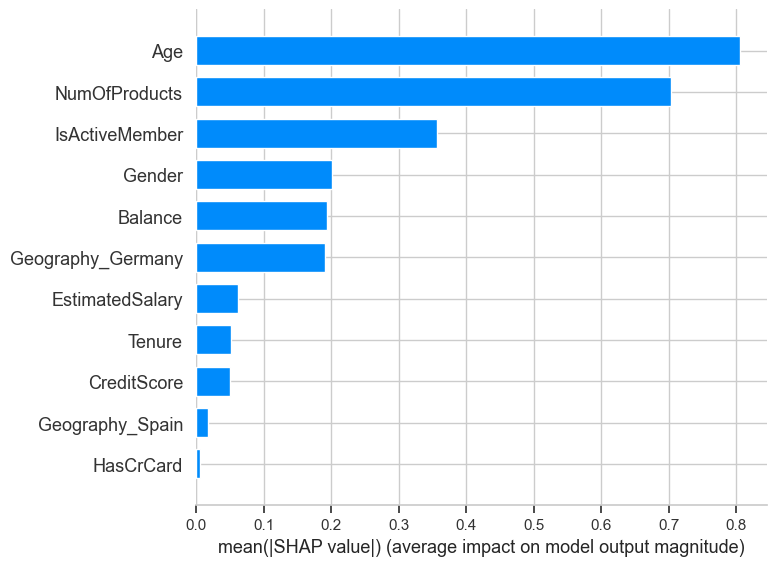

In [50]:
shap.summary_plot(shap_values, X_test_sample, plot_type="bar", show=True)


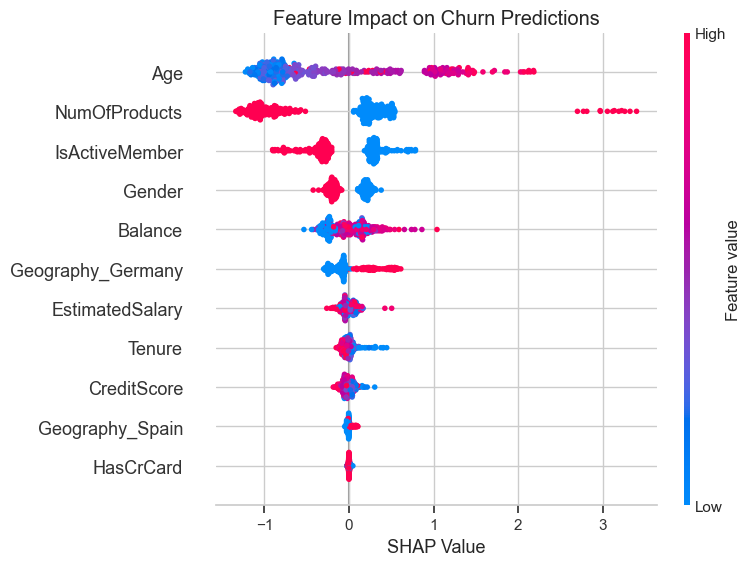

In [51]:
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test_sample, plot_type="dot", show=False)
plt.title("Feature Impact on Churn Predictions")
plt.xlabel("SHAP Value")
plt.tight_layout()
plt.show()

note: The SHAP analysis shows that the factors with the greatest impact on predicting customer churn are age and the number of products used. Older customers and those with fewer products are more likely to leave the bank. Inactive customers also face a higher risk of churn. Other factors, such as account balance and country of residence, also influence the prediction but to a lesser extent. These results can help the bank focus its efforts on the most at-risk groups and improve customer retention.
